# Homework 3

> I pledge my Honor that I have abided by the Stevens Honor System - Joshua Schmidt

imports:

In [285]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree, export_graphviz
from io import StringIO
from IPython.display import Image
from pydotplus import graph_from_dot_data
from sklearn.metrics import accuracy_score, classification_report

# turn off warnings (for sklearn fit function)
import warnings
warnings.filterwarnings("ignore")

random_state = 42

## question 3

In [14]:
tennis_df = pd.DataFrame({
    'day': range(1, 11),
    'outlook': ['sunny', 'sunny', 'overcast', 'rain', 'rain', 'rain', 'overcast', 'sunny', 'sunny', 'rain'],
    'temperature': ['hot', 'hot', 'hot', 'mild', 'cool', 'cool', 'cool', 'mild', 'cool', 'mild'],
    'humidity': ['high', 'high', 'high', 'high', 'normal', 'normal', 'normal', 'high', 'normal', 'normal'],
    'wind': ['weak', 'strong', 'weak', 'weak', 'weak', 'strong', 'strong', 'weak', 'weak', 'weak'],
    'play_tennis': [0, 0, 1, 1, 1, 0, 1, 0, 1, 1],
}).set_index('day')
tennis_df

,outlook,temperature,humidity,wind,play_tennis
day,,,,,
1,sunny,hot,high,weak,0
2,sunny,hot,high,strong,0
3,overcast,hot,high,weak,1
4,rain,mild,high,weak,1
5,rain,cool,normal,weak,1
6,rain,cool,normal,strong,0
7,overcast,cool,normal,strong,1
8,sunny,mild,high,weak,0
9,sunny,cool,normal,weak,1


In [15]:
normalized_tennis_df = tennis_df.copy()

outlook_le = LabelEncoder()
outlook_le.fit(normalized_tennis_df['outlook'])
normalized_tennis_df['outlook']=outlook_le.transform(normalized_tennis_df['outlook'])

temp_le = LabelEncoder()
temp_le.fit(normalized_tennis_df['temperature'])
normalized_tennis_df['temperature']=temp_le.transform(normalized_tennis_df['temperature'])

humidity_le = LabelEncoder()
humidity_le.fit(normalized_tennis_df['humidity'])
normalized_tennis_df['humidity']=humidity_le.transform(normalized_tennis_df['humidity'])

wind_le = LabelEncoder()
wind_le.fit(normalized_tennis_df['wind'])
normalized_tennis_df['wind']=wind_le.transform(normalized_tennis_df['wind'])

normalized_tennis_df

,outlook,temperature,humidity,wind,play_tennis
day,,,,,
1,2,1,0,1,0
2,2,1,0,0,0
3,0,1,0,1,1
4,1,2,0,1,1
5,1,0,1,1,1
6,1,0,1,0,0
7,0,0,1,0,1
8,2,2,0,1,0
9,2,0,1,1,1


|--- outlook <= 1.50
|   |--- wind <= 0.50
|   |   |--- outlook <= 0.50
|   |   |   |--- class: 1
|   |   |--- outlook >  0.50
|   |   |   |--- class: 0
|   |--- wind >  0.50
|   |   |--- class: 1
|--- outlook >  1.50
|   |--- humidity <= 0.50
|   |   |--- class: 0
|   |--- humidity >  0.50
|   |   |--- class: 1



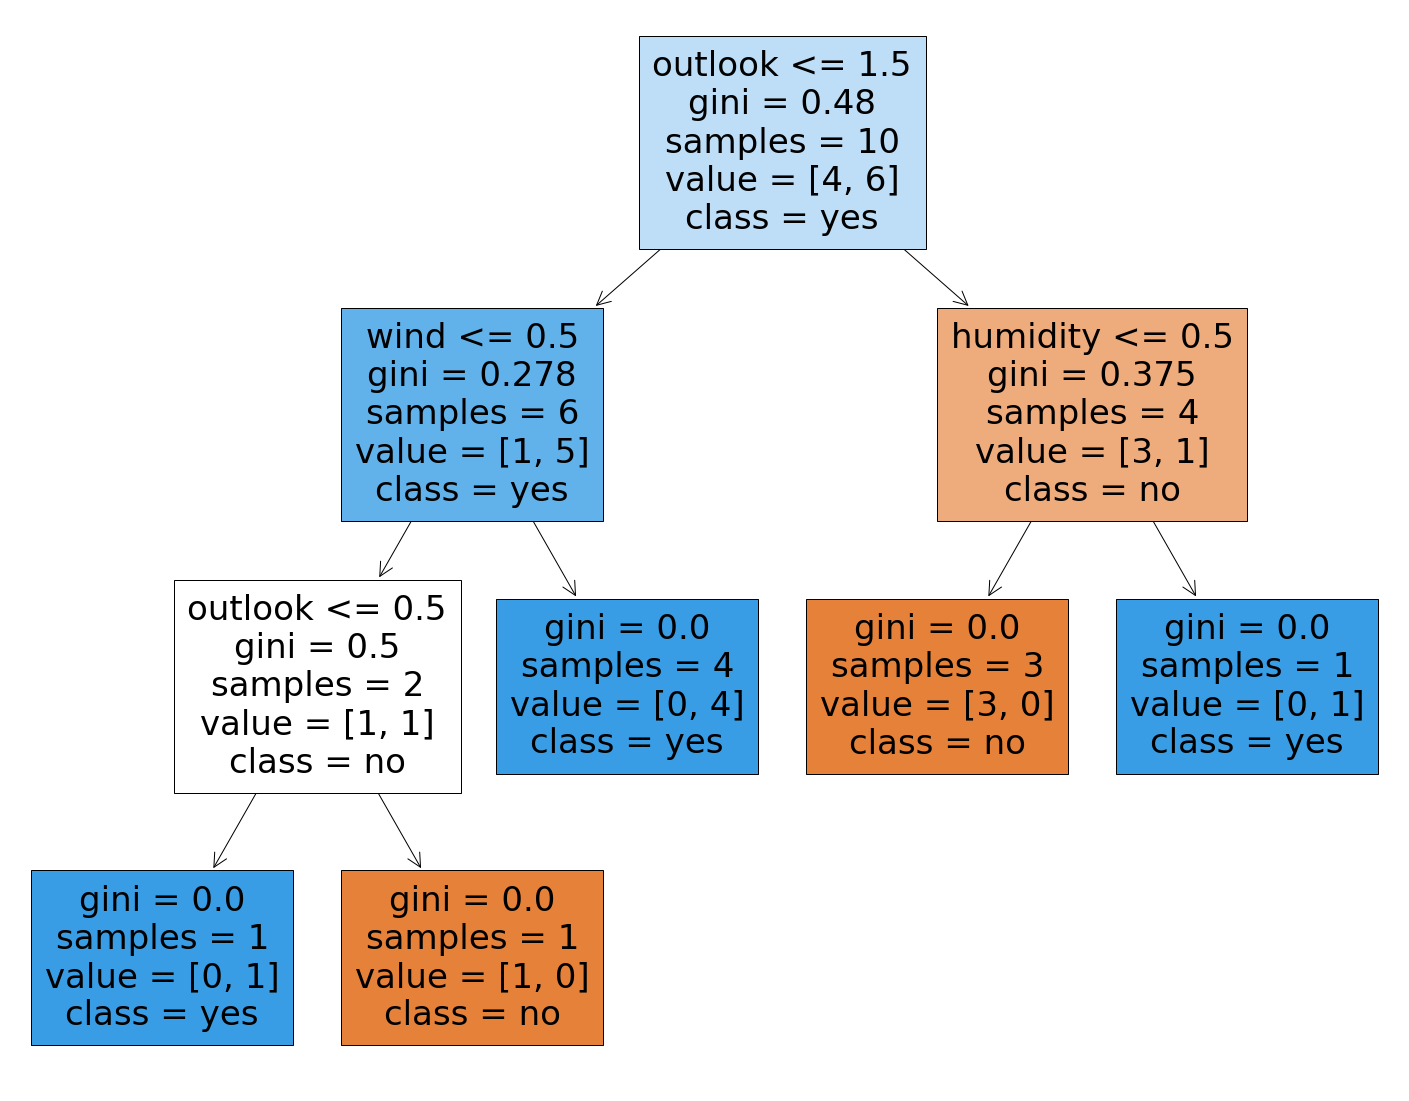

In [32]:
feature_cols = ['outlook', 'temperature', 'humidity', 'wind']
X = normalized_tennis_df[feature_cols]
y = normalized_tennis_df['play_tennis']

clf = DecisionTreeClassifier(random_state=random_state)
clf = clf.fit(X, y)

print(export_text(clf, feature_names=feature_cols))

class_names = ['no', 'yes']

fig = plt.figure(figsize=(25,20))
plot_tree(clf, feature_names=feature_cols,  
               class_names=class_names, filled=True)
plt.show()

In [44]:
print('outlook:', outlook_le.classes_, outlook_le.transform(outlook_le.classes_))
print('temperature:', temp_le.classes_, temp_le.transform(temp_le.classes_))
print('humidity:', humidity_le.classes_, humidity_le.transform(humidity_le.classes_))
print('wind:', wind_le.classes_, wind_le.transform(wind_le.classes_))

outlook: ['overcast' 'rain' 'sunny'] [0 1 2]
temperature: ['cool' 'hot' 'mild'] [0 1 2]
humidity: ['high' 'normal'] [0 1]
wind: ['strong' 'weak'] [0 1]


## question 5

In [46]:
titanic_df = pd.read_csv('./titanic.csv', index_col=0)
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [371]:
titanic_vectorizer = DictVectorizer(sparse=False)
titanic_feature_cols = ['pclass', 'sex', 'age']
target_col = 'survived'
titanic_data = titanic_df[[*titanic_feature_cols, target_col]].dropna()
titanic_features = titanic_data[titanic_feature_cols]
X = titanic_vectorizer.fit_transform(titanic_features.to_dict('records'))
titanic_vectorizer.get_feature_names()
y = titanic_data[target_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

clf = DecisionTreeClassifier(ccp_alpha=0.003)
clf = clf.fit(X_train, y_train)

print(titanic_vectorizer.get_feature_names())

print(export_text(clf, feature_names=titanic_vectorizer.get_feature_names()))

['age', 'pclass=1st', 'pclass=2nd', 'pclass=3rd', 'sex=female', 'sex=male']
|--- sex=female <= 0.50
|   |--- age <= 9.50
|   |   |--- pclass=3rd <= 0.50
|   |   |   |--- class: 1
|   |   |--- pclass=3rd >  0.50
|   |   |   |--- class: 0
|   |--- age >  9.50
|   |   |--- pclass=1st <= 0.50
|   |   |   |--- class: 0
|   |   |--- pclass=1st >  0.50
|   |   |   |--- age <= 17.50
|   |   |   |   |--- class: 1
|   |   |   |--- age >  17.50
|   |   |   |   |--- class: 0
|--- sex=female >  0.50
|   |--- pclass=3rd <= 0.50
|   |   |--- class: 1
|   |--- pclass=3rd >  0.50
|   |   |--- class: 0



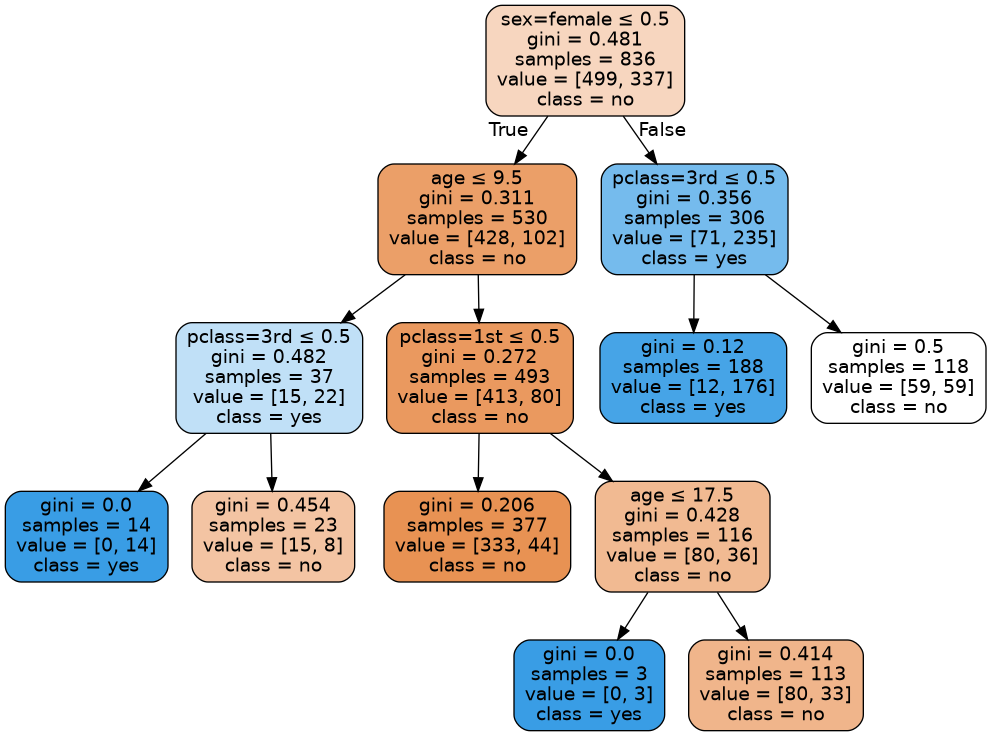

In [372]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=titanic_vectorizer.get_feature_names(),
                class_names=['no', 'yes'])
graph = graph_from_dot_data(dot_data.getvalue())  
graph.write_png('titanic_1.png')
Image(graph.create_png())

In [373]:
train_survive_indexes = np.where(y_train == 1)[0]
train_survive_predictions = clf.predict(X_train[train_survive_indexes])
inv_train_survive_predictions = np.logical_not(train_survive_predictions).astype(int)
print(f'in-sample survive predicted = {(len(train_survive_predictions) - np.count_nonzero(inv_train_survive_predictions)) / len(train_survive_predictions) * 100:.3f}%')

train_fatality_indexes = np.where(y_train == 0)[0]
train_fatality_predictions = clf.predict(X_train[train_fatality_indexes])
print(f'in-sample fatalities predicted = {(len(train_fatality_predictions) - np.count_nonzero(train_fatality_predictions)) / len(train_fatality_predictions) * 100:.3f}%')

test_survive_indexes = np.where(y_test == 1)[0]
test_survive_predictions = clf.predict(X_test[test_survive_indexes])
inv_test_survive_predictions = np.logical_not(test_survive_predictions).astype(int)
print(f'out-of-sample survive predicted = {(len(test_survive_predictions) - np.count_nonzero(inv_test_survive_predictions)) / len(test_survive_predictions) * 100:.3f}%')

test_fatality_indexes = np.where(y_test == 0)[0]
test_fatality_predictions = clf.predict(X_test[test_fatality_indexes])
print(f'out-of-sample fatalities predicted = {(len(test_fatality_predictions) - np.count_nonzero(test_fatality_predictions)) / len(test_fatality_predictions) * 100:.3f}%')

in-sample survive predicted = 57.270%
in-sample fatalities predicted = 97.595%
out-of-sample survive predicted = 48.889%
out-of-sample fatalities predicted = 95.833%


Accuracy: 0.7619047619047619
209
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best params: {'max_leaf_nodes': 6}
[209, 43, 45, 44, 43, 41, 41, 41, 41]
training accuracy: 0.8098086124401914
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       162
           1       1.00      1.00      1.00        48

    accuracy                           1.00       210
   macro avg       1.00      1.00      1.00       210
weighted avg       1.00      1.00      1.00       210



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished


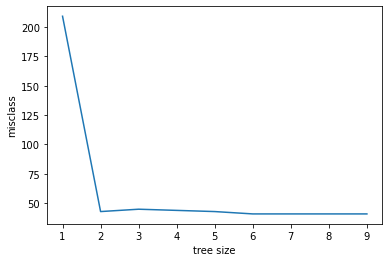

In [335]:
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

k = 4
k_fold_size = len(y_train) // k
print(k_fold_size)

k_fold = KFold(n_splits=k, shuffle=True, random_state=random_state)

gs_clf = GridSearchCV(clf, {
    'max_leaf_nodes': [None, *range(1, 10)]
}, cv=k_fold, verbose=1)

gs_clf.fit(X_train, y_train)
print('best params:', gs_clf.best_params_)

misclassification_counts = []
for score in gs_clf.cv_results_['mean_test_score'][1:]:
    if np.isnan(score):
        score = 0
    misclassification_counts.append(int((1 - score) * k_fold_size))

print(misclassification_counts)

correct_prediction_counts_df = pd.DataFrame({
    'tree size': range(1, 10),
    'misclass': misclassification_counts
})

sns.lineplot(data=correct_prediction_counts_df, x='tree size', y='misclass')

y_test_pred = gs_clf.predict(X_test)

print('training accuracy:', accuracy_score(y_train_pred, y_train))
print(classification_report(y_test_pred, y_pred))

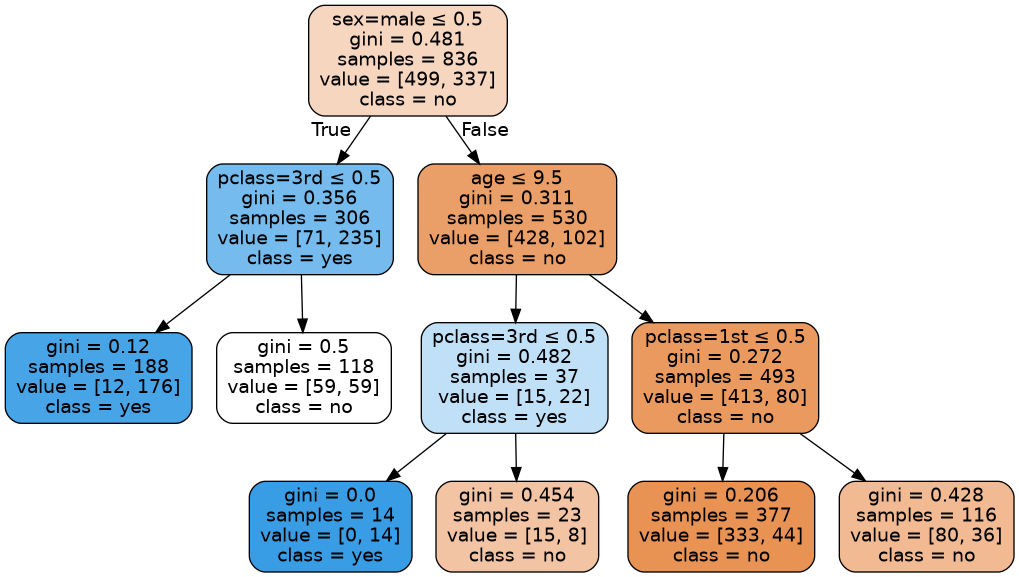

In [274]:
dot_data = StringIO()
export_graphviz(gs_clf.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=titanic_vectorizer.get_feature_names(),
                class_names=['no', 'yes'])
graph = graph_from_dot_data(dot_data.getvalue())  
graph.write_png('titanic_2.png')
Image(graph.create_png())

In [374]:
train_survive_indexes = np.where(y_train == 1)[0]
train_survive_predictions = gs_clf.predict(X_train[train_survive_indexes])
inv_train_survive_predictions = np.logical_not(train_survive_predictions).astype(int)
print(f'in-sample survive predicted = {(len(train_survive_predictions) - np.count_nonzero(inv_train_survive_predictions)) / len(train_survive_predictions) * 100:.3f}%')

train_fatality_indexes = np.where(y_train == 0)[0]
train_fatality_predictions = gs_clf.predict(X_train[train_fatality_indexes])
print(f'in-sample fatalities predicted = {(len(train_fatality_predictions) - np.count_nonzero(train_fatality_predictions)) / len(train_fatality_predictions) * 100:.3f}%')

test_survive_indexes = np.where(y_test == 1)[0]
test_survive_predictions = gs_clf.predict(X_test[test_survive_indexes])
inv_test_survive_predictions = np.logical_not(test_survive_predictions).astype(int)
print(f'out-of-sample survive predicted = {(len(test_survive_predictions) - np.count_nonzero(inv_test_survive_predictions)) / len(test_survive_predictions) * 100:.3f}%')

test_fatality_indexes = np.where(y_test == 0)[0]
test_fatality_predictions = gs_clf.predict(X_test[test_fatality_indexes])
print(f'out-of-sample fatalities predicted = {(len(test_fatality_predictions) - np.count_nonzero(test_fatality_predictions)) / len(test_fatality_predictions) * 100:.3f}%')

in-sample survive predicted = 56.380%
in-sample fatalities predicted = 97.595%
out-of-sample survive predicted = 48.889%
out-of-sample fatalities predicted = 96.667%


There was a slight improvement for the pruned tree vs the original tree (96.667% accuracy vs 95.833%) for out-of-sample fatalities predicted.